# An exploration of the top 100 Spotify hits from 2010-2019

## Table of Contents
* [Set Up](#setup)
    * [Import libraries](#libraries)
    * [Set conventions](#conventions)
    * [Make data accessibile](#access)

* [Data Exploration](#explore)
    * [Characteristics](#charas)
    * [Display (pre-normalization)](#previs)
        * [Notes on the histograms](#histnotes)
    * [Feature Engineering](#featengin)
        
* [Predictions](#predict)
    
* [Normalization](#norm)
    * [Split Data](#split)
    * [Calculate](#calcnorm)
        * [clipping](#clipping)
        * [z-score](#zscore)
    * [Display (post-normalization)](#postvis)
        * [Notes on the violin plots](#violinnotes)

## Set Up <a class="anchor" id="setup"></a>

### Import libraries <a class="anchor" id="libraries"></a>

In [1]:
from os import path
import csv
import opendatasets as od
import pandas as pd
import numpy as np
import seaborn as sns

import IPython
import IPython.display
from ipywidgets import widgets, interactive, fixed
import matplotlib as mpl
import matplotlib.pyplot as plt

import dataframe_image as dfi

### Set conventions <a class="anchor" id="conventions"></a>

In [2]:
# conventions
%matplotlib inline

mpl.rcParams['figure.figsize'] = (12,6)
mpl.rcParams['axes.grid'] = False

sns.set(style="whitegrid")

### Make data accessibe<a class="anchor" id="access"></a>
Dataset found on [Kaggle](https://www.kaggle.com/datasets/muhmores/spotify-top-100-songs-of-20152019)

In [3]:
# TODO: update file download parameters for outsider user

# download dataset
if not path.exists('hits_2010-2019.csv'):
    od.download('https://www.kaggle.com/datasets/muhmores/spotify-top-100-songs-of-20152019')

In [4]:
# covert to dataframe
data = pd.read_csv('hits_2010-2019.csv', sep=',')
df = pd.DataFrame(data)

## Data Exploration <a class="anchor" id="explore"></a>

### Characteristics <a class="anchor" id="charas"></a>

First look at the shape of the data frame. This will tell us the size of the dataset we are working with. We know from the Kaggle link to expect 1000 rows (100 hits/year x 10 years) and 17 columns of data, 17000 data points. 

In [5]:
# (rows, columns)
df.shape

(1003, 17)

In [6]:
print("column labels: ")
for i, label in enumerate(list(df.columns)):
    print(i, label)

column labels: 
0 title
1 artist
2 top genre
3 year released
4 added
5 bpm
6 nrgy
7 dnce
8 dB
9 live
10 val
11 dur
12 acous
13 spch
14 pop
15 top year
16 artist type


In [7]:
df.dtypes

title             object
artist            object
top genre         object
year released    float64
added             object
bpm              float64
nrgy             float64
dnce             float64
dB               float64
live             float64
val              float64
dur              float64
acous            float64
spch             float64
pop              float64
top year         float64
artist type       object
dtype: object

In [8]:
# print first few rows
# note: data sorted sequentially increasing by 'top year'
df.head()

,title,artist,top genre,year released,added,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop,top year,artist type
0,STARSTRUKK (feat. Katy Perry),3OH!3,dance pop,2009.0,2022‑02‑17,140.0,81.0,61.0,-6.0,23.0,23.0,203.0,0.0,6.0,70.0,2010.0,Duo
1,My First Kiss (feat. Ke$ha),3OH!3,dance pop,2010.0,2022‑02‑17,138.0,89.0,68.0,-4.0,36.0,83.0,192.0,1.0,8.0,68.0,2010.0,Duo
2,I Need A Dollar,Aloe Blacc,pop soul,2010.0,2022‑02‑17,95.0,48.0,84.0,-7.0,9.0,96.0,243.0,20.0,3.0,72.0,2010.0,Solo
3,Airplanes (feat. Hayley Williams of Paramore),B.o.B,atl hip hop,2010.0,2022‑02‑17,93.0,87.0,66.0,-4.0,4.0,38.0,180.0,11.0,12.0,80.0,2010.0,Solo
4,Nothin' on You (feat. Bruno Mars),B.o.B,atl hip hop,2010.0,2022‑02‑17,104.0,85.0,69.0,-6.0,9.0,74.0,268.0,39.0,5.0,79.0,2010.0,Solo


Below is the list of features measured on a scale from 0-100, 0 is low and 100 is high respectively to the meaning of each feature. For more information on each feature visit the [Spotify API](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features)

energy (nrgy), danceability (dnce, live (live), valence (val), acousticness (acous), speechiness (spch), popularity (pop)

In [9]:
#  function will only return stats for numerical data columns
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
year released,1000.0,2014.390,3.241359,1975.0,2012.0,2014.0,2017.00,2021.0
bpm,1000.0,121.262,26.238022,65.0,100.0,122.0,134.00,206.0
nrgy,1000.0,69.502,15.961415,6.0,59.0,71.0,81.25,98.0
dnce,1000.0,66.876,13.121921,19.0,59.0,68.0,75.00,96.0
dB,1000.0,-5.663,2.025224,-18.0,-7.0,-5.0,-4.00,-1.0
live,1000.0,17.911,13.431511,2.0,9.0,12.0,23.00,83.0
val,1000.0,50.901,21.563399,4.0,35.0,50.5,68.00,97.0
dur,1000.0,220.406,39.927677,113.0,197.0,216.0,237.00,688.0
acous,1000.0,14.369,19.454030,0.0,2.0,6.0,19.00,98.0
spch,1000.0,10.064,9.276743,2.0,4.0,6.0,12.00,53.0


### Display (before normalization) <a class="anchor" id="previs"></a>

We are mapping the spread and density of each feature. This allows us to get a general idea of the distribution of each data type. We will refer to these graphs later when prepping the data for further analysis.

In [10]:
# create a dropdown menu so we can easily switch between histograms
def opt(_list):
    feature = widgets.Dropdown(options=_list,
                 value='year released',
                 description='Feature:',
                 disabled=False,)
    return feature

# define function for a histogram, feature vs. top year
def hist2d(feature:str, df):
    sns.histplot(data=df, x='top year', y=feature, stat='count', discrete=(True, True), cbar=True)
    plt.show()

In [11]:
# create list of all features we are displaying
features_list = list(df.columns)[3:]

# return the histograms
feature = opt(features_list)
interactive(hist2d, feature=feature, df=fixed(df))

interactive(children=(Dropdown(description='Feature:', options=('year released', 'added', 'bpm', 'nrgy', 'dnce…

#### Notes on the histograms:<a class="anchor" id="histnotes"></a>

- The distribution of 'year released' initially does not make sense. How can a song be a chart topper in a year prior to it's release? 
    - Upon further investigation, I learned that the 'year released' column was determined by the album release 
        date. The singles that charted off the album were released ahead of time in promotion of the album. 
    - There are 75 songs with this error present.
    
- The 'top genre' feature is a bit of a mess to look at. But, based on the colorbar, one of the genres dominated the charts. Almost half of all songs fell into this one genre. The popularity of that genre was cut basically in half in 2017 and that trend has not returned since.

- Beginnging to see small trend down of 'dur' suggesting pop songs are becoming shorter. Are attention spans wanning?

- There is also a small trend down of energy. Although these trends are too small to be considered actual trends. The extent of the data is too small to draw such conclusions (only 10 years). 

- 'acous' and 'live' reminds us that most music is electronically produced today. Possibly though they are becoming more acoustic, meaning the interest in organic sounds is becoming popular again. 

### Feature Engineering <a class="anchor" id="featengin"></a>

In [12]:
# drop empty rows
df.dropna(how='all', inplace=True)

# we only care about columns of numerical measure, drop everything else
DROP_list = ['title', 'artist', 'top genre', 'added', 'top year', 'artist type']
df_num = pd.DataFrame(df.drop(labels=DROP_list, axis=1, inplace=False))

In [13]:
# df_err.shape[0] is the number of data points with release years inconsistent with the top year
df_err = df.loc[df['year released'] > df['top year']]

# when we run the next cell, shape[0] should be zero
print('# of inconsistent data points is', df_err.shape[0])

# of inconsistent data points is 75


From the histogram we noticed inconsistencies in the distribution. There are 75 inconsistent data points in the 'year released' column. We are more interested in how many years 'year released' is offset from 'top year' than we are in the actual release date. With that in mind, let's remeasure/redefine 'year released'.

In [14]:
df_num['year released'] = df_num['year released'].sub(df['top year'])

Note: A negative 'year released' value now means that the song was released x years before it hit the charts. A positive 'year released' value indicates how many years before the album released did the single peak. 

In [15]:
# convert columns that measure on a scale of 0-100 to 0-1
list1 = ['nrgy', 'dnce', 'live', 'val', 'acous', 'spch', 'pop']
df_num[list1] = df_num[list1].div(100)

In [16]:
# return some data to verify changes have been made
df_num.head()

,year released,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
0,-1.0,140.0,0.81,0.61,-6.0,0.23,0.23,203.0,0.00,0.06,0.70
1,0.0,138.0,0.89,0.68,-4.0,0.36,0.83,192.0,0.01,0.08,0.68
2,0.0,95.0,0.48,0.84,-7.0,0.09,0.96,243.0,0.20,0.03,0.72
3,0.0,93.0,0.87,0.66,-4.0,0.04,0.38,180.0,0.11,0.12,0.80
4,0.0,104.0,0.85,0.69,-6.0,0.09,0.74,268.0,0.39,0.05,0.79


## Predictions <a class="anchor" id="predict"></a>

The goal is create an algorithm that will forecast the features of next year's pop hits. "Intuition" in this case is based on the range I expected the algorithm to output within. For most of the features, I expect around 68% of the forecasting to fall in the range of the mean +/- 1 std. I will specify later on why I can't do this for all the features.

In [17]:
# I printed already when exploring the characteristics of the dataset
# I'm printing it again to reminds us of the spread of the data
df_num.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
year released,1000.0,-0.11000,1.687824,-44.00,0.00,0.000,0.0000,10.00
bpm,1000.0,121.26200,26.238022,65.00,100.00,122.000,134.0000,206.00
nrgy,1000.0,0.69502,0.159614,0.06,0.59,0.710,0.8125,0.98
dnce,1000.0,0.66876,0.131219,0.19,0.59,0.680,0.7500,0.96
dB,1000.0,-5.66300,2.025224,-18.00,-7.00,-5.000,-4.0000,-1.00
live,1000.0,0.17911,0.134315,0.02,0.09,0.120,0.2300,0.83
val,1000.0,0.50901,0.215634,0.04,0.35,0.505,0.6800,0.97
dur,1000.0,220.40600,39.927677,113.00,197.00,216.000,237.0000,688.00
acous,1000.0,0.14369,0.194540,0.00,0.02,0.060,0.1900,0.98
spch,1000.0,0.10064,0.092767,0.02,0.04,0.060,0.1200,0.53


In [18]:
# create lower and upper bounds of expected output range
LOWER = df_num.mean(axis=0, skipna=True) - df_num.std(axis=0, skipna=True)
UPPER = df_num.mean(axis=0, skipna=True) + df_num.std(axis=0, skipna=True)
df_predict = pd.DataFrame({'lower bound': LOWER, 
                           'upper bound': UPPER},
                          index=list(df_num.columns))
# print the predictions
df_predict = df_predict.transpose()
df_predict

,year released,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
lower bound,-1.797824,95.023978,0.535406,0.537541,-7.688224,0.044795,0.293376,180.478323,-0.05085,0.007873,0.660322
upper bound,1.577824,147.500022,0.854634,0.799979,-3.637776,0.313425,0.724644,260.333677,0.33823,0.193407,0.836478


Make corrections to upper and lower bounds based on what is logically possible
1. Bounds of 'year released' can only be integers and must be <= 0.
2. The column 'acous' can only be >= 0 or <= 1. 

In [19]:
# 1
df_predict.loc['upper bound', 'year released'] = 0

# 2
df_predict.loc['lower bound', 'acous'] = 0

# 3 
list2 = ['year released', 'bpm', 'dB', 'dur']
df_predict[list1] = df_predict[list1].round(2)
df_predict[list2] = df_predict[list2].round(0)

In [20]:
df_predict

,year released,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
lower bound,-2.0,95.0,0.54,0.54,-8.0,0.04,0.29,180.0,0.00,0.01,0.66
upper bound,0.0,148.0,0.85,0.80,-4.0,0.31,0.72,260.0,0.34,0.19,0.84


## Normalization <a class="anchor" id="norm"></a>

### Split the data* <a class="anchor" id="split"></a>
Data is not split at random because of the time dependency aspect of this exploration. The data size is a power of 10 so it splits evenly.

70%, training set data from 2010-2016 

20%, validation set data from 2017-2018

10%, test set data from 2019

In [21]:
column_indices = {name: i for i, name in enumerate(df_num.columns)}

n = len(df_num)

# 70%
train_df = df_num[0:int(n*0.7)]
# 20%
val_df = df_num[int(n*0.7):int(n*0.9)]
# 10%
test_df = df_num[int(n*0.9):]

num_features = df_num.shape[1]

### Calculate norms <a class="anchor" id="calcnorm"></a>

#### clipping <a class="anchor" id="clipping"></a>
Adjust for obvious outliers.

In [22]:
# keep original value where condition False 
df_num['dB'].mask(df_num['dB'] < -14, inplace=True)
df_num['dur'].mask(df_num['dur'] > 400, inplace=True)
df_num['year released'].mask(df_num['year released'] < -5, inplace=True)

#### z-score <a class="anchor" id="zscore"></a>
x' = (value - mean) / std 

In [23]:
# preventing bias:
# only using training mean and std so the other values don't have access to validation and test sets

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

### Display (after normalization) <a class="anchor" id="postvis"></a>

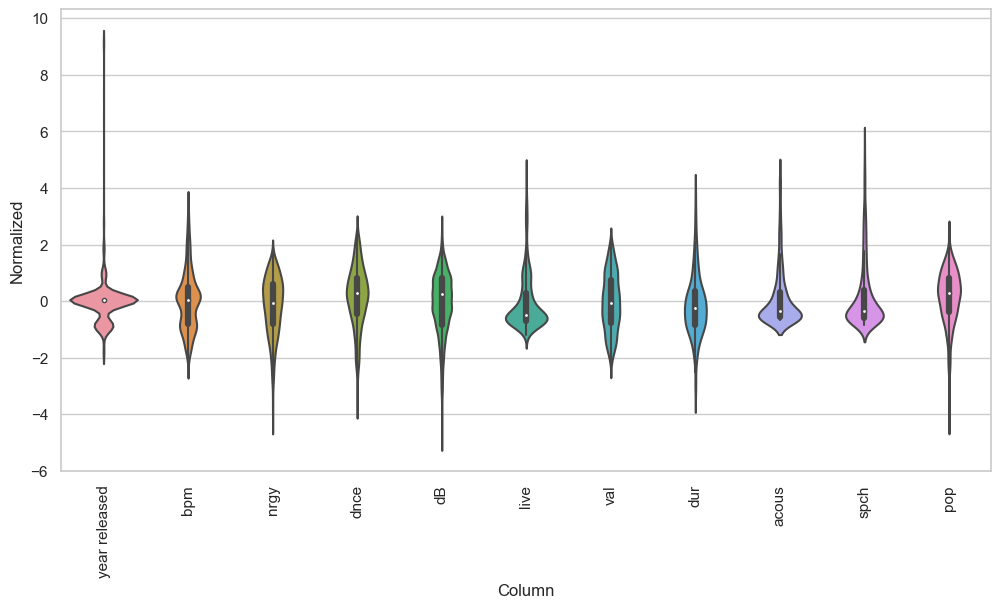

In [24]:
df_std = (df_num - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df_num.keys(), rotation=90)